# MSc TCC Machine-learning in Materials Chemistry Assessed Problems Supporting Code

### Candidate Number: 1091127

In [ ]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import seaborn as sns

import ijson
import json
from pymatgen.core import Structure
from pymatgen.core import Lattice, Element
from ase.io import write

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.core import Structure, Lattice
from ase import Atoms
from dscribe.descriptors import SOAP

from load_atoms import view

## Question 1 Supporting Code


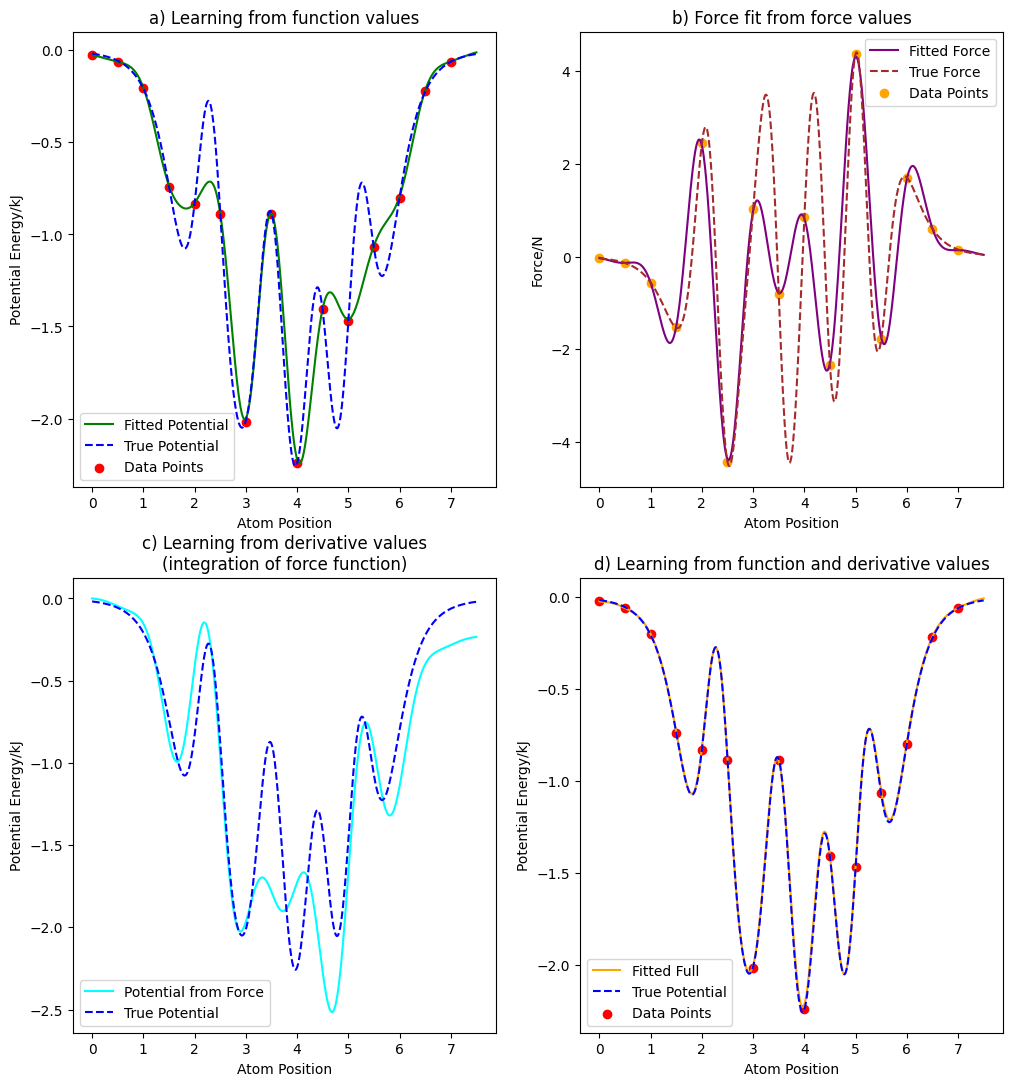

RMSD for potential fit: 0.2155
RMSD for force fit: 1.4520
RMSD for full fit: 0.0108


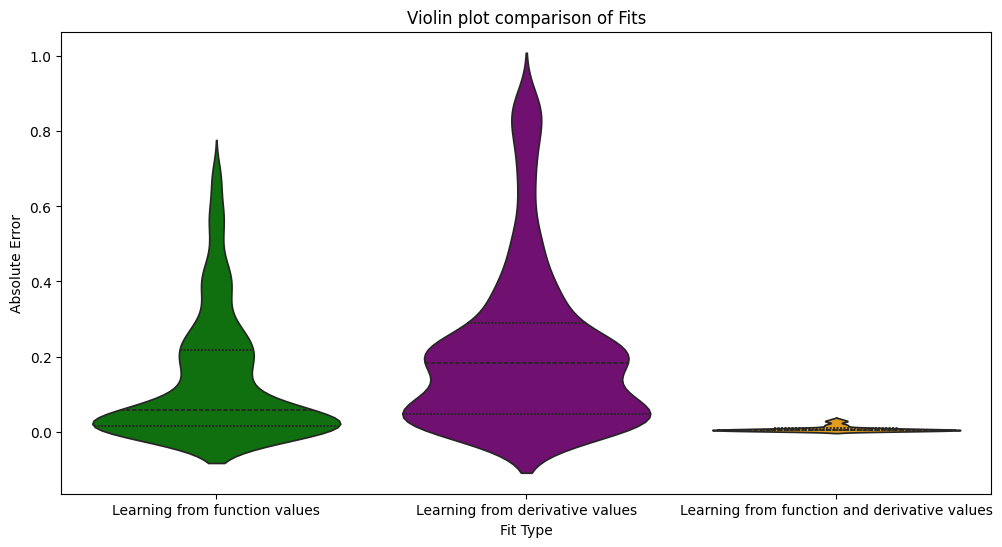

In [108]:
# Setting the hyperparameters for the Gaussian process regression
length_scale = 0.3 # Length scale for the kernel function

# Making the function to give the initial data values. Using an offset 
# simple lenard Jones potential (with error) to simulate the potential
# parallel to a string of atoms a given distance away.

def potential_function(atom_position, other_atoms, 
                       distance_from_atom_string=1.0, with_error=True):
    """
    Calculate the potential energy of an atom in a system of atoms.
    
    Parameters:
    atom_position (np.array): Position of the atom for which to calculate the potential.
    other_atoms (np.array): Positions of other atoms in the system.
    distance_from_atom_string (float): Distance from the atom string for potential 
    calculation.
    with_error (bool): Whether to add random noise to the potential energy.
    
    Returns:
    float: Calculated potential energy.
    """
    # Simple potential calculation with an error
    energy = 0.0
    for other_atom in other_atoms:
        # Using a simple distance calculation
        distance = np.sqrt(distance_from_atom_string**2 + (other_atom-atom_position)**2)  
        energy += 4 * ((1 / distance) ** 12 
                  - (1 / distance) ** 6) # Lenard Jones potential term
    if with_error:
        # Adding random noise to the energy as error
        energy += rd.uniform(-0.01, 0.01)
    else:
        energy += 0
    return energy 

# Taking the derivative of the potential function to give the force on the atom
# parallel to the string of atoms
def force_function(atom_position, other_atoms, distance_from_atom_string=1.0, with_error=True):
    """
    Calculate the force on an atom in a system of atoms.
    
    Parameters:
    atom_position (np.array): Position of the atom for which to calculate the force.
    other_atoms (np.array): Positions of other atoms in the system.
    distance_from_atom_string (float): Distance from the atom string for force calculation.
    with_error (bool): Whether to add random noise to the force.
    
    Returns:
    float: Calculated force on the atom.
    """
    force = 0.0
    for other_atom in other_atoms:
        distance = np.sqrt(distance_from_atom_string**2 + (atom_position-other_atom)**2)
        # Derivative of Lenard Jones potential term
        force -= 24 * (atom_position-other_atom) * (2*(1 / (distance )) ** 12 
                  - (1 / (distance )) ** 6) / (distance**2)  
    if with_error:
        # Adding random noise to the force as error
        return force + rd.uniform(-0.01, 0.01)
    else:
        return force 

# Defining the kernel function for the Gaussian process regression
def kernel(descriptor_i, descriptor_j):
    """
    Squared exponential kernel function.
    
    Parameters:
    descriptor_i (np.array): First input vector.
    descriptor_j (np.array): Second input vector.
    length_scale (float): Length scale hyperparameter for the kernel.
    
    Returns:
    float: Value of the kernel function.
    """
    return np.exp(- ((np.linalg.norm(descriptor_i - descriptor_j)) ** 2) / (2*length_scale ** 2))

# Defining the derivative of the kernel function
def kernel_derivative(descriptor_i, descriptor_j):
    """
    Derivative of the squared exponential kernel function.
    
    Parameters:
    descriptor_i (np.array): First input vector.
    descriptor_j (np.array): Second input vector.
    length_scale (float): Length scale hyperparameter for the kernel.
    
    Returns:
    float: Value of the derivative of the kernel function.
    """
    return - (descriptor_i - descriptor_j) * kernel(descriptor_i, descriptor_j) / length_scale ** 2

# Defining the double partial derivative of the kernel function
def kernel_double_derivative(descriptor_i, descriptor_j):
    """
    Double derivative of the squared exponential kernel function.
    
    Parameters:
    descriptor_i (np.array): First input vector.
    descriptor_j (np.array): Second input vector.
    length_scale (float): Length scale hyperparameter for the kernel.
    
    Returns:
    float: Value of the double derivative of the kernel function.
    """
    return -(kernel(descriptor_i, descriptor_j) / length_scale ** 2 
            - (descriptor_i - descriptor_j) ** 2 * kernel(descriptor_i, descriptor_j) / length_scale ** 4)

# Constructing the reference database of data locations and labels

potential_list = np.array([])

force_list = np.array([])

x_list = np.array([])

atom_string = np.array([2.3, 3.5, 4.4, 5.2])  # Positions of other atoms

for i in range(15):
    # Generating atom positions
    atom_position = i * 0.5
    
    # Calculating potential and force for the atom
    potential = potential_function(atom_position, atom_string)
    force = force_function(atom_position, atom_string)
    
    # Appending to lists
    potential_list = np.append(potential_list, potential)
    force_list = np.append(force_list, force)
    x_list = np.append(x_list, atom_position)

# Now calculating the vector c (model parameters) using just potential values

c_pot = np.array([])

# Calculating the kernel matrix for the potential

k_matrix_rows = []

for i in range(len(x_list)):
    k_row = []
    for j in range(len(x_list)):
        k_row.append(kernel(x_list[i], x_list[j]))
    k_matrix_rows.append(k_row)

k_matrix_pot = np.array(k_matrix_rows)

k_error_matrix_pot = k_matrix_pot + np.eye(len(x_list)) * 0.01  # Adding a small error term

# Inverting this matrix and multiplying by the potential vector to find c_pot

c_pot = np.matmul(np.linalg.inv(k_error_matrix_pot), potential_list)

# Using this c_pot to define a function to calculate the potential at any position

def potential_function_fit(x):
    """
    Calculate the potential energy using the fitted model parameters.
    
    Parameters:
    x (float): Position at which to calculate the potential.
    
    Returns:
    float: Calculated potential energy at position x.
    """
    result = 0.0
    for i in range(len(x_list)):
        result += c_pot[i] * kernel(x, x_list[i])
    return result

# Constructing a line of potential values using the fitted model parameters (for plotting)
x_fit_pot = np.linspace(0, 7.5, 1000)
potential_fit = np.array([potential_function_fit(x) for x in x_fit_pot])


# True potential values for the fitted line
true_potential_fit = np.array([potential_function(x, atom_string, with_error=False) 
                               for x in x_fit_pot])

# Now calculating the vector c (model parameters) using just force values

c_force = np.array([])

# Calculating the kernel matrix for the force

k_matrix_rows = []

for i in range(len(x_list)):
    k_row = []
    for j in range(len(x_list)):
        k_row.append(kernel(x_list[i], x_list[j]))
    k_matrix_rows.append(k_row)

k_matrix_force = np.array(k_matrix_rows)

# Adding a small error term

k_error_matrix_force = k_matrix_force + np.eye(len(x_list)) * 0.01  

# Inverting this matrix and multiplying by force vector to find c_force

c_force = np.matmul(np.linalg.inv(k_error_matrix_force), force_list)

# Using this c_force to define a function to calculate the force at any position

def force_function_fit(x):
    """
    Calculate the force energy using the fitted model parameters.
    
    Parameters:
    x (float): Position at which to calculate the force.
    
    Returns:
    float: Calculated force energy at position x.
    """
    result = 0.0
    for i in range(len(x_list)):
        result += c_force[i] * kernel(x, x_list[i])
    return result

# Constructing a line of force values using the fitted model parameters (for plotting)
x_fit_force = np.linspace(0, 7.5, 1000)
force_fit = np.array([force_function_fit(x) for x in x_fit_force])


# True force values for the fitted line
true_force_fit = np.array([force_function(x, atom_string, with_error=False) 
                               for x in x_fit_force])

# Using simple trapezoidal rule for integration of the force function (to get the potential plot)

potential_from_force = [0.0]  # Initial potential energy
for i in range(1, len(x_fit_force)):
    # Using trapezoidal rule to integrate the force to get potential
    delta_x = x_fit_force[i] - x_fit_force[i-1]
    potential_from_force.append(potential_from_force[-1] + 0.5 * (force_fit[i] + force_fit[i-1]) 
                                * delta_x)

# Finally constructing the c vector (model parameters) form the potential and force values

c_full = np.array([])

# Calculating the kernel matrix for the full model

k_matrix_rows = []

# First half (columns 0 to n): kernel values and derivatives
for i in range(len(x_list)):
    k_row = []
    # Kernel values
    for j in range(len(x_list)):
        k_row.append(kernel(x_list[i], x_list[j]))
    # Kernel derivatives
    for j in range(len(x_list)):
        k_row.append(kernel_derivative(x_list[i], x_list[j]))
    k_matrix_rows.append(k_row)

# Second half (columns n to 2n): kernel derivatives and double derivatives
for i in range(len(x_list)):
    k_row = []
    # Kernel derivatives
    for j in range(len(x_list)):
        k_row.append(kernel_derivative(x_list[i], x_list[j]))
    # Kernel double derivatives
    for j in range(len(x_list)):
        k_row.append(kernel_double_derivative(x_list[j], x_list[i]))
    k_matrix_rows.append(k_row)

k_matrix_full = np.array(k_matrix_rows)

# Adding a small error term
k_error_matrix_full = k_matrix_full + np.eye(len(x_list)*2) * 0.01 

# Inverting this matrix and multiplying by full vector to find c_full

c_full = np.matmul(np.linalg.inv(k_error_matrix_full), np.append(potential_list, force_list))

# Using this c_full to define a function to calculate the potential at any position

def full_function_fit(x):
    """
    Calculate the full energy using the fitted model parameters.
    
    Parameters:
    x (float): Position at which to calculate the full.
    
    Returns:
    float: Calculated full energy at position x.
    """
    result = 0.0
    for i in range(len(x_list)):
        result += c_full[i] * kernel(x, x_list[i])
    for i in range(len(x_list)):
        result += c_full[len(x_list) + i] * kernel_derivative(x, x_list[i])
    return result

# Constructing a line of full values using the fitted model parameters
x_fit_full = np.linspace(0, 7.5, 1000)
full_fit = np.array([full_function_fit(x) for x in x_fit_full])

# Plotting the fitted potential line
plt.figure(figsize=(12, 13))
plt.subplot(2, 2, 1)
plt.plot(x_fit_pot, potential_fit, label='Fitted Potential', color='green')
plt.plot(x_fit_pot, true_potential_fit, label='True Potential', color='blue', linestyle='--')
plt.scatter(x_list, potential_list, color='red', label='Data Points')
plt.title('a) Learning from function values')
plt.xlabel('Atom Position')
plt.ylabel('Potential Energy/kJ')
plt.legend()

# Plotting the fitted force line and potential from force integration
plt.subplot(2, 2, 2)
plt.plot(x_fit_force, force_fit, label='Fitted Force', color='purple')
plt.plot(x_fit_force, true_force_fit, label='True Force', color='brown', linestyle='--')
plt.scatter(x_list, force_list, color='orange', label='Data Points')
plt.title('b) Force fit from force values')
plt.xlabel('Atom Position')
plt.ylabel('Force/N')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(x_fit_force, potential_from_force, label='Potential from Force', color='cyan')
plt.plot(x_fit_pot, true_potential_fit, label='True Potential', color='blue', linestyle='--')
plt.title('c) Learning from derivative values\n(integration of force function)')
plt.xlabel('Atom Position')
plt.ylabel('Potential Energy/kJ')
plt.legend()

# Plotting the line fitted from both potential and force values
plt.subplot(2, 2, 4)
plt.plot(x_fit_full, full_fit, label='Fitted Full', color='orange')
plt.plot(x_fit_pot, true_potential_fit, label='True Potential', color='blue', linestyle='--')
plt.scatter(x_list, potential_list, color='red', label='Data Points')
plt.title('d) Learning from function and derivative values')
plt.xlabel('Atom Position')
plt.ylabel('Potential Energy/kJ')
plt.legend()

plt.show()

# Performing a simple RMSD calculation to compare each fitted potential and the true potential
def rmsd(true_values, fitted_values):
    """
    Calculate the Root Mean Square Deviation (RMSD) between true and fitted values.
    
    Parameters:
    true_values (np.array): True values.
    fitted_values (np.array): Fitted values.
    
    Returns:
    float: RMSD value.
    """
    return np.sqrt(np.mean((true_values - fitted_values) ** 2))
rmsd_potential = rmsd(true_potential_fit, potential_fit)
rmsd_force = rmsd(true_force_fit, force_fit)
rmsd_full = rmsd(true_potential_fit, full_fit)
print(f"RMSD for potential fit: {rmsd_potential:.4f}")
print(f"RMSD for force fit: {rmsd_force:.4f}")
print(f"RMSD for full fit: {rmsd_full:.4f}")

# Making a violin plot of absolute error to compare the potential, force and full fits

plt.figure(figsize=(12, 6))
sns.violinplot(data=[ np.abs(true_potential_fit - potential_fit),
                     np.abs(true_potential_fit - potential_from_force),
                     np.abs(true_potential_fit - full_fit)],
               palette=["green", "purple", "orange"],
               density_norm='width', inner='quartile')
plt.xticks([0, 1, 2], ['Learning from function values', 'Learning from derivative values', 'Learning from function and derivative values'])
plt.title('Violin plot comparison of Fits')
plt.ylabel('Absolute Error')
plt.xlabel('Fit Type')
plt.show()

## Question 2 Supporting Code

In [ ]:
# This cell was written with help from ChatGPT, which provided guidance on how to read large JSON files efficiently.

# This script reads the large JSON file of all structures and extracts structures containing Xenon atoms.
input_path = "/mnt/c/Users/capta/Downloads/MPtrj_2022.9_full.json"
output_path = "xenon_structures.json"

with open(input_path, 'rb') as infile, open(output_path, 'w') as outfile:
    outfile.write('{\n')
    first = True

    for top_key, sub_dict in ijson.kvitems(infile, ''):
        for subkey, entry in sub_dict.items():
            sites = entry.get("structure", {}).get("sites", [])
            if any(spec.get("element") == "Xe" for site in sites for spec in site.get("species", [])):
                if not first:
                    outfile.write(',\n')
                json.dump({top_key: {subkey: entry}}, outfile, default=str)
                first = False
                break  # Only need the first matching sub-entry per top-level key

    outfile.write('\n}\n')

print("✅ Done! Xenon structures saved to:", output_path)


✅ Done! Xenon structures saved to: xenon_structures.json


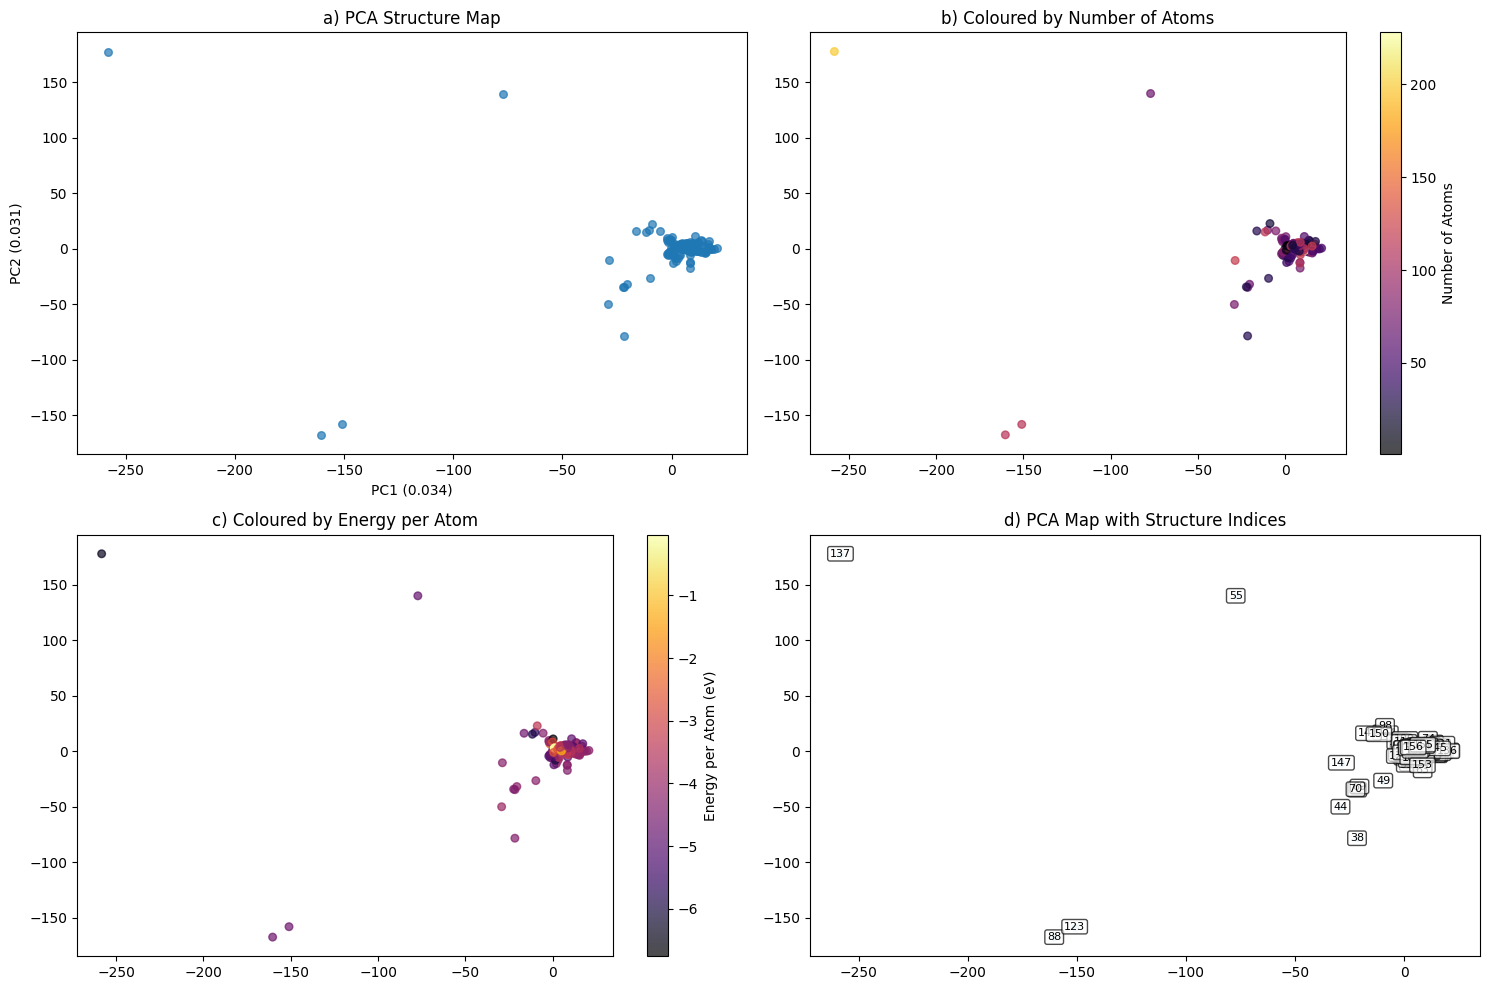


Summary:
  Structures analyzed: 157
  Energy range: -6.759 to -0.030 eV/atom
  Atom count range: 1 to 228 atoms
  All elements present: ['Ag', 'As', 'Au', 'B', 'Ba', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'F', 'Fe', 'Ge', 'H', 'Hg', 'I', 'Ir', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pt', 'Re', 'Ru', 'S', 'Sb', 'Sr', 'Tc', 'Te', 'V', 'W', 'Xe', 'Zn']
  SOAP matrix shape: (157, 144600)


In [91]:

# Creating the structure maps from the JSON file of xenon structures

# Parse the JSON file of xenon structures 
# This was also made with help form AI because the created file had incorrect formatting
json_file = "xenon_structures.json" 

all_data = {}
with open(json_file, 'r') as f:
    lines = f.readlines()

# Skip first line because it's just '{'
start_line = 1 if lines[0].strip() == '{' else 0

for line_num, line in enumerate(lines[start_line:], start_line + 1):
    # Clean up the line
    line = line.strip()
    if not line or line == '}':
        continue
    
    # Remove trailing comma if present
    if line.endswith(','):
        line = line[:-1]
    
    # Parse JSON line and add it to 'all_data'
    # Added try-except to handle any parsing errors
    try:
        line_data = json.loads(line)
        all_data.update(line_data)
    except:
        print(f"✗ Failed line {line_num}")

# Now extracting structures and energies and converting to ASE Atoms objects
ase_structures = {}
energies_dict = {}

for material_id, material_data in all_data.items():
    for sub_id, sub_data in material_data.items():
        if 'structure' in sub_data:
            struct_dict = sub_data['structure']
            
            # Using the lattice information instead of the xyz coordinates
            # to define the structure
            # Create lattice
            matrix = struct_dict['lattice']['matrix']
            matrix = [[float(x) for x in row] for row in matrix]
            lattice = Lattice(matrix)
            
            # Extract sites
            species = []
            coords = []
            for site in struct_dict['sites']:
                element = site['species'][0]['element']
                species.append(element)
                frac_coords = [float(x) for x in site['abc']]
                coords.append(frac_coords)
            
            # Create structure
            structure = Structure(lattice, species, coords)
            
            # Convert to ASE
            atoms = Atoms(
                symbols=[str(site.specie) for site in structure],
                positions=structure.cart_coords,
                cell=structure.lattice.matrix,
                pbc=True
            )
            
            struct_id = f"{material_id}_{sub_id}"
            ase_structures[struct_id] = atoms
            
            # Extract energy
            energies_dict[struct_id] = float(sub_data['energy_per_atom'])

# Calculating SOAP features 

# Get unique elements
all_elements = set()
for atoms in ase_structures.values():
    all_elements.update(atoms.get_chemical_symbols())
all_elements = sorted(list(all_elements))

# Create SOAP descriptor
soap = SOAP(
    species=all_elements,
    periodic=True,
    r_cut=4.0,  # Using r_cut=3.0 to prevent memory issues
    n_max=5,    # Using n_max=5 to prevent memory issues
    l_max=4,    # Using l_max=3 to prevent memory issues
    sigma=1.0,
    rbf="gto",
    average="outer",  
    sparse=False
)

# Calculate SOAP for structures 
soap_data = []
structure_names = []
energies = []
num_atoms_list = []

for struct_id, atoms in ase_structures.items():               
    features = soap.create(atoms)
    features_flat = features.flatten()
    soap_data.append(features_flat)
    structure_names.append(struct_id)
    energies.append(energies_dict.get(struct_id, 0.0))
    num_atoms_list.append(len(atoms))
    

# Performing the PCA Analysis as done in the class
soap_matrix = np.array(soap_data)

# Standardize
scaler = StandardScaler()
soap_scaled = scaler.fit_transform(soap_matrix)

# PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(soap_scaled)

# Creating plots
plt.figure(figsize=(15, 10))

# Basic plot
plt.subplot(2, 2, 1)
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.7, s=30)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.title('a) PCA Structure Map')

# Plot with points coloured by number of atoms
plt.subplot(2, 2, 2)
scatter = plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=num_atoms_list, 
                        cmap='inferno', alpha=0.7, s=30)
plt.colorbar(scatter, label='Number of Atoms')
plt.title('b) Coloured by Number of Atoms')

# Plot with points coloured by number of energy
plt.subplot(2, 2, 3)
scatter = plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=energies, 
                        cmap='inferno', alpha=0.7, s=30)
plt.colorbar(scatter, label='Energy per Atom (eV)')
plt.title('c) Coloured by Energy per Atom')

# Label points by index (to identify outlying structures)
plt.subplot(2, 2, 4)
# Plot points (small and light colored)
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c='lightblue', alpha=0.5, s=20)

# Add index labels
for i, (x, y) in enumerate(pca_coords):
    plt.annotate(str(i), (x, y), fontsize=8, ha='center', va='center', 
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
plt.title('d) PCA Map with Structure Indices')
    
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary:")
print(f"  Structures analyzed: {len(structure_names)}")
print(f"  Energy range: {min(energies):.3f} to {max(energies):.3f} eV/atom")
print(f"  Atom count range: {min(num_atoms_list)} to {max(num_atoms_list)} atoms")
print(f"  All elements present: {all_elements}")
print(f"  SOAP matrix shape: {soap_matrix.shape}")

Viewing structure: mp-555132_mp-666556-0-0
Composition: Bi2F18Xe2
Number of atoms: 22
Energy per atom: -3.468 eV/atom



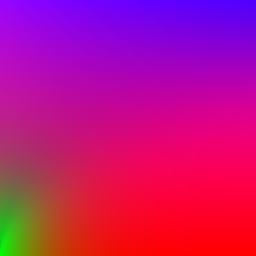

In [109]:
# Cell to view specific interesting (outlying) structures

idx = 156
structure_id = structure_names[idx]
atoms = ase_structures[structure_id]

print(f"Viewing structure: {structure_names[idx]}")
print(f"Composition: {atoms.get_chemical_formula()}")
print(f"Number of atoms: {len(atoms)}")
print(f"Energy per atom: {energies_dict[structure_id]:.3f} eV/atom")

view(atoms, show_bonds=True, start_rotation=False)

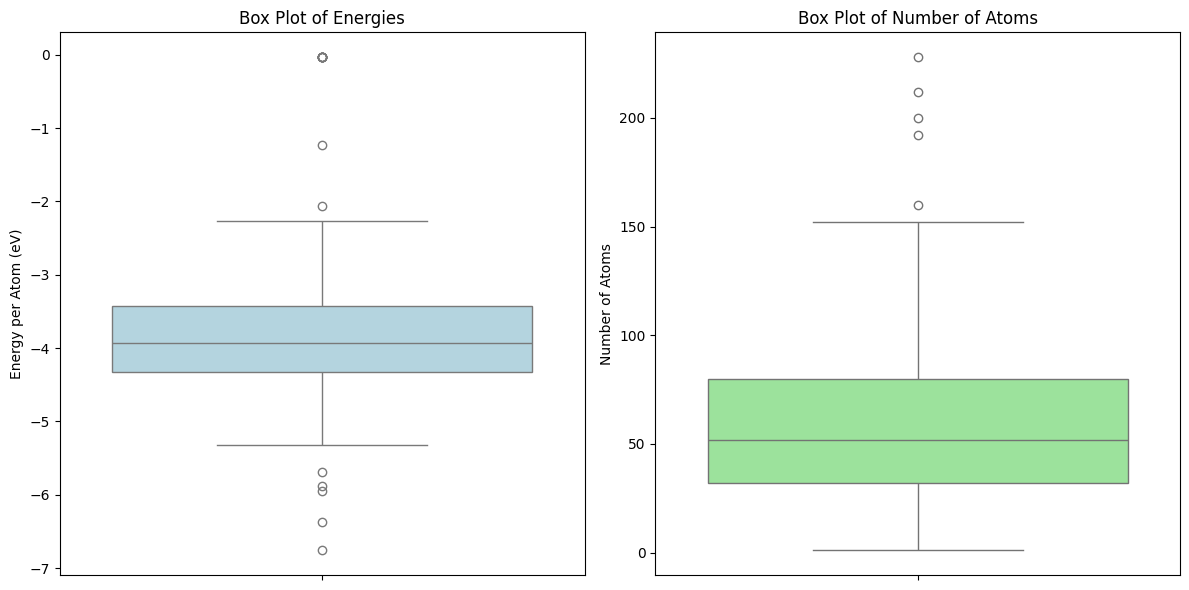

In [ ]:
# Plotting box plots of the different energy values and number of atoms

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=energies, color='lightblue')
plt.title('Box Plot of Energies')
plt.ylabel('Energy per Atom (eV)')
plt.subplot(1, 2, 2)
sns.boxplot(data=num_atoms_list, color='lightgreen')
plt.title('Box Plot of Number of Atoms')
plt.ylabel('Number of Atoms')
plt.tight_layout()
plt.show()